## U-Net++
- [참고](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)
- U-Net을 향상시키기위해서 DenseNet의 Dense block을 사용했다.
- 다음과 같은 3가지는 기존의 U-Net을 따른다.
    1. Skip Connection에서 Conv layer가 있어서 Encoder와 Decoder의 feature map 사이에 의미적인 차이를 연결해주는 역할을 한다.
    2. Skip Connection에서 Dense skip을 사용해서 Gradient flow를 향상시킨다.
    3. [model pruning](https://www.tensorflow.org/model_optimization/guide/pruning?hl=ko)....  
        having deep supervision, which enables model pruning and improves or in the worst case achieves comparable performance to using only one loss layer. => ?
---
### 1. UNet++ Architecture
![image](https://user-images.githubusercontent.com/48716219/98207024-59ed5b00-1f7e-11eb-8bee-9daec27ddb62.png)
  
### 2. Re-designed Skip Pathways
![image](https://user-images.githubusercontent.com/48716219/98208037-ee0bf200-1f7f-11eb-9c13-7f3c76e74950.png)
- skip pathway는 3개의 Conv layer의 Dense Conv block으로 구성되어 있음
- 각 Conv layer는 동일한 Desne Block의 이전 Conv layer의 출력을 하위 Dense Block의 Up-sampling된 출력과 결합하는 Concatenation layer가 선행된다.
- 다음과 같이 공식화  
![image](https://user-images.githubusercontent.com/48716219/98212506-07fd0300-1f87-11eb-8f85-88aa5aff502b.png)
    - $H()$는 Conv 뒤의 Activation 함수이고, $U()$는 up-sampling layer, $[]$는 Concatenation layer이다.
    - 이 부분이 DenseNet의 아이디어
> 주요한 아이디어는 합치기 이전에 인코더와 디코더 사이의 feature map을 의미적으로 연결시키는 것이다.

### 3. Deep Supervision
![image](https://user-images.githubusercontent.com/48716219/98215820-9c696480-1f8b-11eb-9824-379d0c14b90d.png)
- Deep Supervision? ([참고](https://eremo2002.tistory.com/116))
    - Deep Neural Network에서 classifier를 여러 개 두어 성능을 올리는 것
    - 모든 Segmentation branch들을 평균을 낸 출력으로 사용해서 더 정확하다
    - 최종 Segmentation map Segmentation branch들 중에서 오직 하나만 선택되서 더 빠르다..?
- 중첩된 skip pathway로 인해서 UNet++은 여러개의 semantic level에서 full resolution의 feature map을 생성한다. 그러므로 loss값은 4개의 semantic 수준에서 추정된다.
- binary cross-entropy와 dice coefficient를 혼합한 loss 함수를 사용  
![image](https://user-images.githubusercontent.com/48716219/98221733-59ab8a80-1f93-11eb-8603-c78106a2993e.png)
    - $N$은 batch size를 의미한다

---

# KITTI 데이터셋 수집과 구축

## 라이브러리 import

In [2]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## 데이터 확인

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

train_paths = glob(os.path.join(dir_path, 'semantic', '*'))
train_paths[:5]

['/home/aiffel0042/aiffel/semantic_segmentation/data/training/semantic/000178_10.png',
 '/home/aiffel0042/aiffel/semantic_segmentation/data/training/semantic/000175_10.png',
 '/home/aiffel0042/aiffel/semantic_segmentation/data/training/semantic/000039_10.png',
 '/home/aiffel0042/aiffel/semantic_segmentation/data/training/semantic/000008_10.png',
 '/home/aiffel0042/aiffel/semantic_segmentation/data/training/semantic/000087_10.png']

In [4]:
check_path = train_paths[0]
seg = Image.open(check_path)
seg_arr = np.array(seg)
classes = np.unique(seg_arr)
classes, len(classes)

(array([ 4,  6,  7,  8, 13, 14, 17, 19, 20, 21, 22, 23, 26], dtype=uint8), 13)

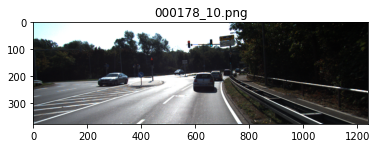

In [5]:
origin_img_paths = glob(os.path.join(dir_path, 'image_2', '*'))

origin_img_path = os.path.join(dir_path, 'image_2', check_path.split('/')[-1])
if os.path.exists(origin_img_path) :
    img = Image.open(origin_img_path)
    img_arr = np.array(img)
    plt.imshow(img_arr)
    plt.title(check_path.split('/')[-1])
    plt.show()

In [6]:
len(classes)

13

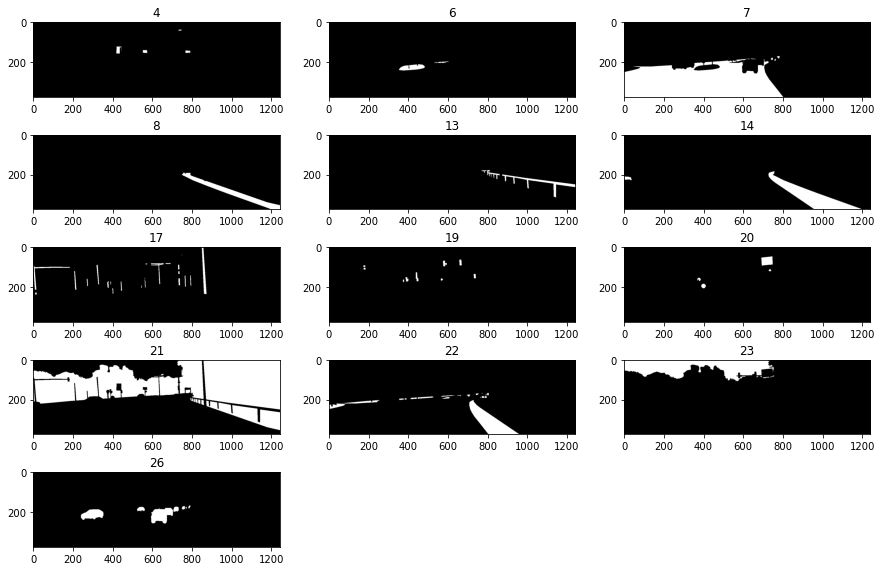

In [7]:
i = 0
plt.figure(figsize=(15, 10))
for class_ in classes :
    i += 1
    plt.subplot(5, 3, i)
    plt.imshow(np.where(seg_arr==class_, 255, 0), 'gray')
    plt.title(class_)
plt.show()

위에서 확인해본 결과는 **도로=7**, 차량=26으로 확인할 수 있다.

## 데이터 로더 만들기

### Albumentation을 활용, Data Augmentation

In [8]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

### augmentation 적용한 데이터 확인

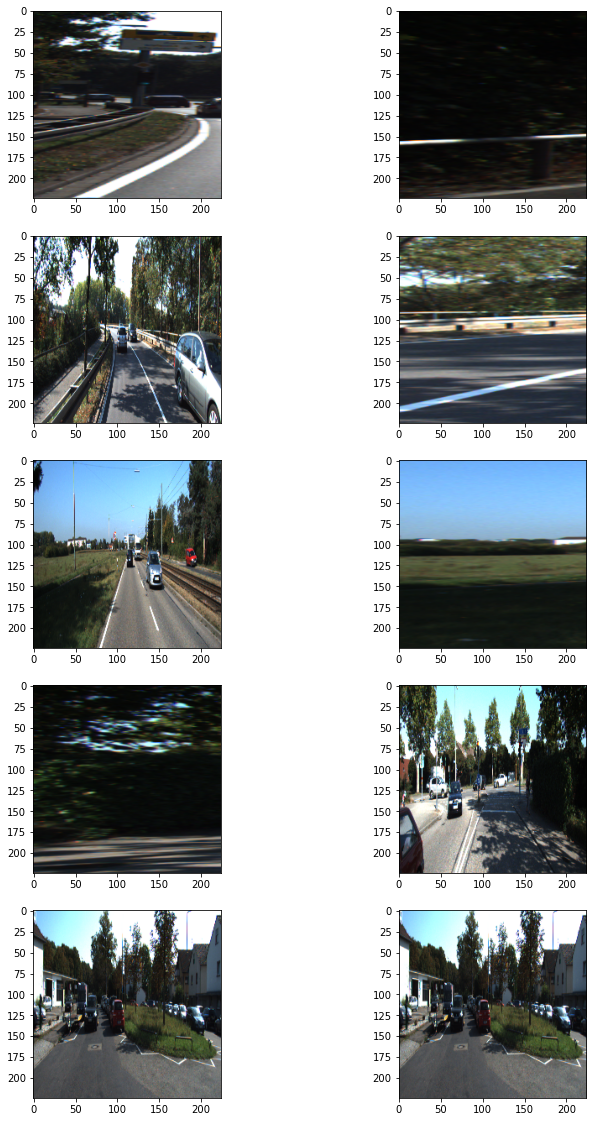

In [9]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### Generator 구현

In [10]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [23]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    batch_size=8,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=8,
    augmentation=test_preproc,
    is_train=False
)

In [24]:
next(iter(train_generator))[0].shape

(8, 224, 224, 3)

In [25]:
next(iter(train_generator))[1].shape

(8, 224, 224)

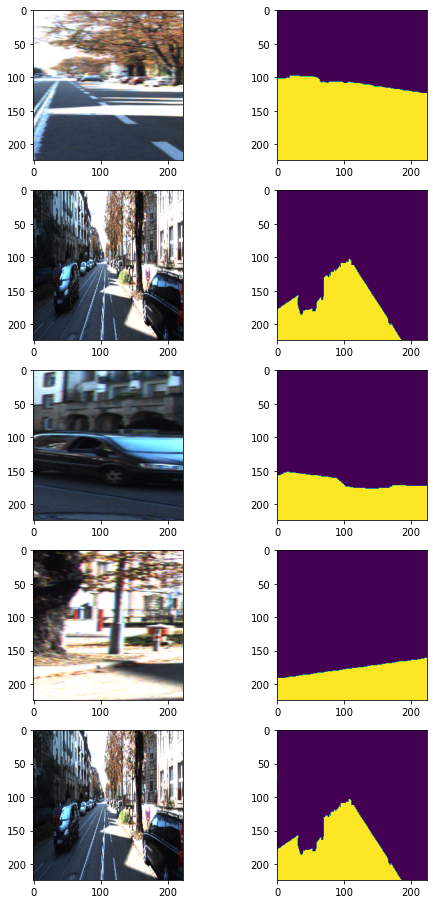

In [26]:
plt.figure(figsize=(8, 16))
for i in range(5) :
    data = next(iter(train_generator))
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(data[0][0, :, :])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(data[1][0, :, :])
plt.show()

# U-Net++ 모델의 구현

### 기존의 U-Net
![image](https://user-images.githubusercontent.com/48716219/98504248-e018e280-2299-11eb-874d-32286e77d652.png)
- 논문의 이미지에서는 이미지의 사이즈가 input과 output이 다르다. 그 이유는?
    - Encoding해주는 부분에서 padding을 해주지 않고 convolution을 수행하면서 사이즈는 점점 줄어들고
    - 이미 이렇게 작아진 output을 upsampling을 해주어도 이미 소실된 정보들로 인해서 사이즈는 encoder와 decoder의 부분은 다르게 나온다.
    - 하지만 코드상으로는 그러한 부분이 없이 모두 padding을 'same'으로 주면서 이러한 차이가 없고 skip connection을 활용한 부분에도 crop하고 concat을 해주는 것이 아닌 바로 concat을 해주었다.
```python
def build_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # size 줄음

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # size 줄음

    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # size 줄음

    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  # size 줄음

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model
```

### U-Net 구현 및 학습

In [51]:
def build_UNet(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # size 줄음

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # size 줄음

    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # size 줄음

    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  # size 줄음

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [52]:
unet = build_UNet()
unet.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 224, 224, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_96[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_97[0][0]                  
______________________________________________________________________________________

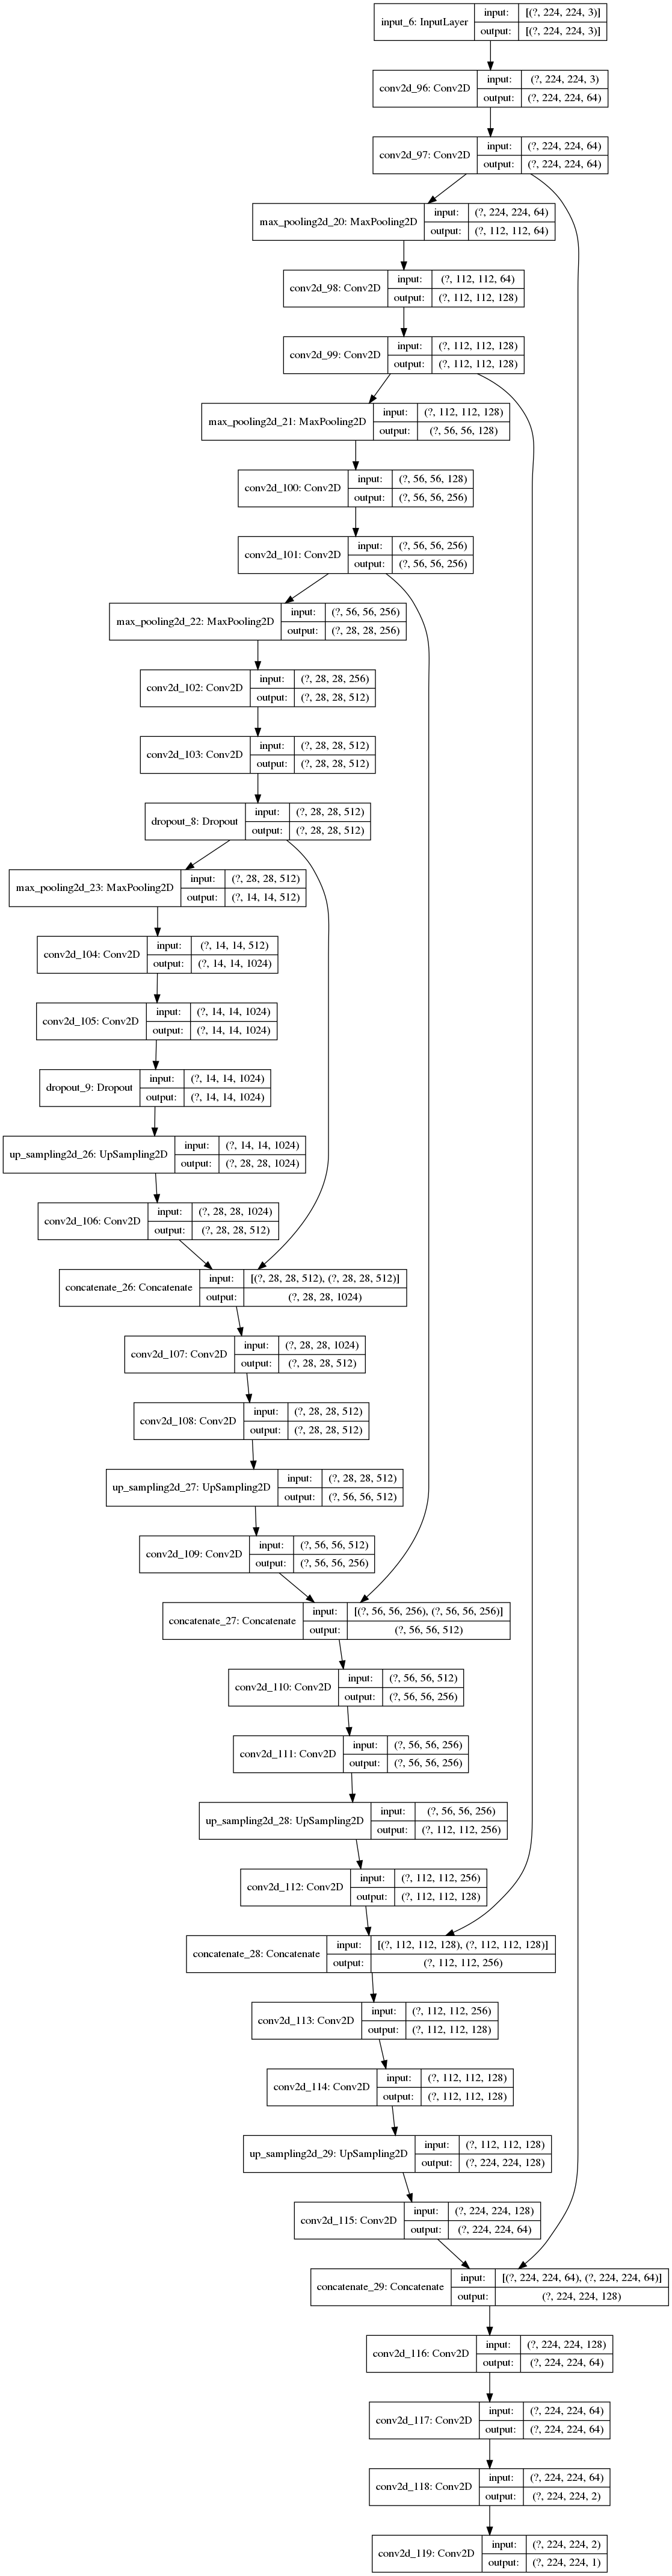

In [53]:
tf.keras.utils.plot_model(unet, './UNet.png', show_shapes=True)

In [54]:
unet.compile(
    optimizer = Adam(lr=1e-4),
#     loss = my_loss(),
    loss = 'binary_crossentropy'
             )
unet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Epoch 1/100
22/22 [==============================] - 7s 318ms/step - loss: 0.4227 - val_loss: 0.0507
Epoch 2/100
22/22 [==============================] - 7s 310ms/step - loss: 0.1071 - val_loss: 0.0723
Epoch 3/100
22/22 [==============================] - 7s 311ms/step - loss: 0.0583 - val_loss: 0.0616
Epoch 4/100
22/22 [==============================] - 7s 312ms/step - loss: 0.0585 - val_loss: 0.0471
Epoch 5/100
22/22 [==============================] - 7s 312ms/step - loss: 0.0404 - val_loss: 0.0428
Epoch 6/100
22/22 [==============================] - 7s 313ms/step - loss: 0.0437 - val_loss: 0.0329
Epoch 7/100
22/22 [==============================] - 7s 318ms/step - loss: 0.0389 - val_loss: 0.0354
Epoch 8/100
22/22 [==============================] - 7s 319ms/step - loss: 0.0396 - val_loss: 0.0334
Epoch 9/100
22/22 [==============================] - 7s 314ms/step - loss: 0.0331 - val_loss: 0.0309
Epoch 10/100
22/22 [==============================] - 7s 314ms/step - loss: 0.0651 - val_lo

In [ ]:
unet.save('./unet.h5')
del unet

### U-Net++ 구현 및 학습

In [33]:
def build_UNet_Plus(input_shape=(224, 224, 3), n = 32) :
    
    filters = [n, n*2, n*4, n*8, n*16]
    
    inputs = Input(input_shape)
    
    #conv0_0
    conv001 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn001 = BatchNormalization()(conv001)
    act001 = Activation('relu')(bn001)
    conv002 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act001)
    bn002 = BatchNormalization()(conv002)
    conv00 = Activation('relu')(bn002)
    
    #conv1_0
    conv00_down = MaxPooling2D(strides=2)(conv00)
    conv101 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv00_down)
    bn101 = BatchNormalization()(conv101)
    act101 = Activation('relu')(bn101)
    conv102 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act101)
    bn102 = BatchNormalization()(conv102)
    conv10 = Activation('relu')(bn102)
    
    #conv2_0
    conv10_down = MaxPooling2D(strides=2)(conv10)
    conv201 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv10_down)
    bn201 = BatchNormalization()(conv201)
    act201 = Activation('relu')(bn201)
    conv202 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act201)
    bn202 = BatchNormalization()(conv202)
    conv20 = Activation('relu')(bn202)
    
    #conv3_0
    conv20_down = MaxPooling2D(strides=2)(conv20)
    conv301 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv20_down)
    bn301 = BatchNormalization()(conv301)
    act301 = Activation('relu')(bn301)
    conv302 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act301)
    bn302 = BatchNormalization()(conv302)
    conv30 = Activation('relu')(bn302)
    
    #conv4_0
    conv30_down = MaxPooling2D(strides=2)(conv30)
    conv401 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv30_down)
    bn401 = BatchNormalization()(conv401)
    act401 = Activation('relu')(bn401)
    conv402 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act401)
    bn402 = BatchNormalization()(conv402)
    conv40 = Activation('relu')(bn402)
    
    
    
    #conv0_1
    conv10_up = UpSampling2D()(conv10)
    conv01_in = Concatenate()([conv00, conv10_up])
    
    conv011 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv01_in)
    bn011 = BatchNormalization()(conv011)
    act011 = Activation('relu')(bn011)
    conv012 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act011)
    bn012 = BatchNormalization()(conv012)
    conv01 = Activation('relu')(bn012)
    
    #conv1_1
    conv20_up = UpSampling2D()(conv20)
    conv11_in = Concatenate()([conv10, conv20_up])
    
    conv111 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv11_in)
    bn111 = BatchNormalization()(conv111)
    act111 = Activation('relu')(bn111)
    conv112 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act111)
    bn112 = BatchNormalization()(conv112)
    conv11 = Activation('relu')(bn112)
    
    #conv2_1
    conv30_up = UpSampling2D()(conv30)
    conv21_in = Concatenate()([conv20, conv30_up])
    
    conv211 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv21_in)
    bn211 = BatchNormalization()(conv211)
    act211 = Activation('relu')(bn211)
    conv212 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act211)
    bn212 = BatchNormalization()(conv212)
    conv21 = Activation('relu')(bn212)
    
    #conv3_1
    conv40_up = UpSampling2D()(conv40)
    conv31_in = Concatenate()([conv30, conv40_up])
    
    conv311 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv31_in)
    bn311 = BatchNormalization()(conv311)
    act311 = Activation('relu')(bn311)
    conv312 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act311)
    bn312 = BatchNormalization()(conv312)
    conv31 = Activation('relu')(bn312)
    
    
    
    #conv0_2
    conv11_up = UpSampling2D()(conv11)
    conv02_in = Concatenate()([conv00, conv01, conv11_up])
    
    conv021 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv02_in)
    bn021 = BatchNormalization()(conv021)
    act021 = Activation('relu')(bn021)
    conv022 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act021)
    bn022 = BatchNormalization()(conv022)
    conv02 = Activation('relu')(bn022)
    
    #conv1_2
    conv21_up = UpSampling2D()(conv21)
    conv12_in = Concatenate()([conv10, conv11, conv21_up])
    
    conv121 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv12_in)
    bn121 = BatchNormalization()(conv121)
    act121 = Activation('relu')(bn121)
    conv122 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act121)
    bn122 = BatchNormalization()(conv122)
    conv12 = Activation('relu')(bn122)
    
    #conv2_2
    conv31_up = UpSampling2D()(conv31)
    conv22_in = Concatenate()([conv20, conv21, conv31_up])
    
    conv221 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv22_in)
    bn221 = BatchNormalization()(conv221)
    act221 = Activation('relu')(bn221)
    conv222 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act221)
    bn222 = BatchNormalization()(conv222)
    conv22 = Activation('relu')(bn222)
    
    
    
    #conv0_3
    conv12_up = UpSampling2D()(conv12)
    conv03_in = Concatenate()([conv00, conv01, conv02, conv12_up])
    
    conv031 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv03_in)
    bn031 = BatchNormalization()(conv031)
    act031 = Activation('relu')(bn031)
    conv032 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act031)
    bn032 = BatchNormalization()(conv032)
    conv03 = Activation('relu')(bn032)
    
    #conv1_3
    conv22_up = UpSampling2D()(conv22)
    conv13_in = Concatenate()([conv10, conv11, conv12, conv22_up])
    
    conv131 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv13_in)
    bn131 = BatchNormalization()(conv131)
    act131 = Activation('relu')(bn131)
    conv132 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act131)
    bn132 = BatchNormalization()(conv132)
    conv13 = Activation('relu')(bn132)
    
    
    
    #conv0_4
    conv13_up = UpSampling2D()(conv13)
    conv04_in = Concatenate()([conv00, conv01, conv02, conv03, conv13_up])
    
    conv041 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv04_in)
    bn041 = BatchNormalization()(conv041)
    act041 = Activation('relu')(bn041)
    conv042 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act041)
    bn042 = BatchNormalization()(conv042)
    conv04 = Activation('relu')(bn042)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv04)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [34]:
unet_pp = build_UNet_Plus()

In [35]:
unet_pp.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0_1 (Conv2D)              (None, 224, 224, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv0_0_1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

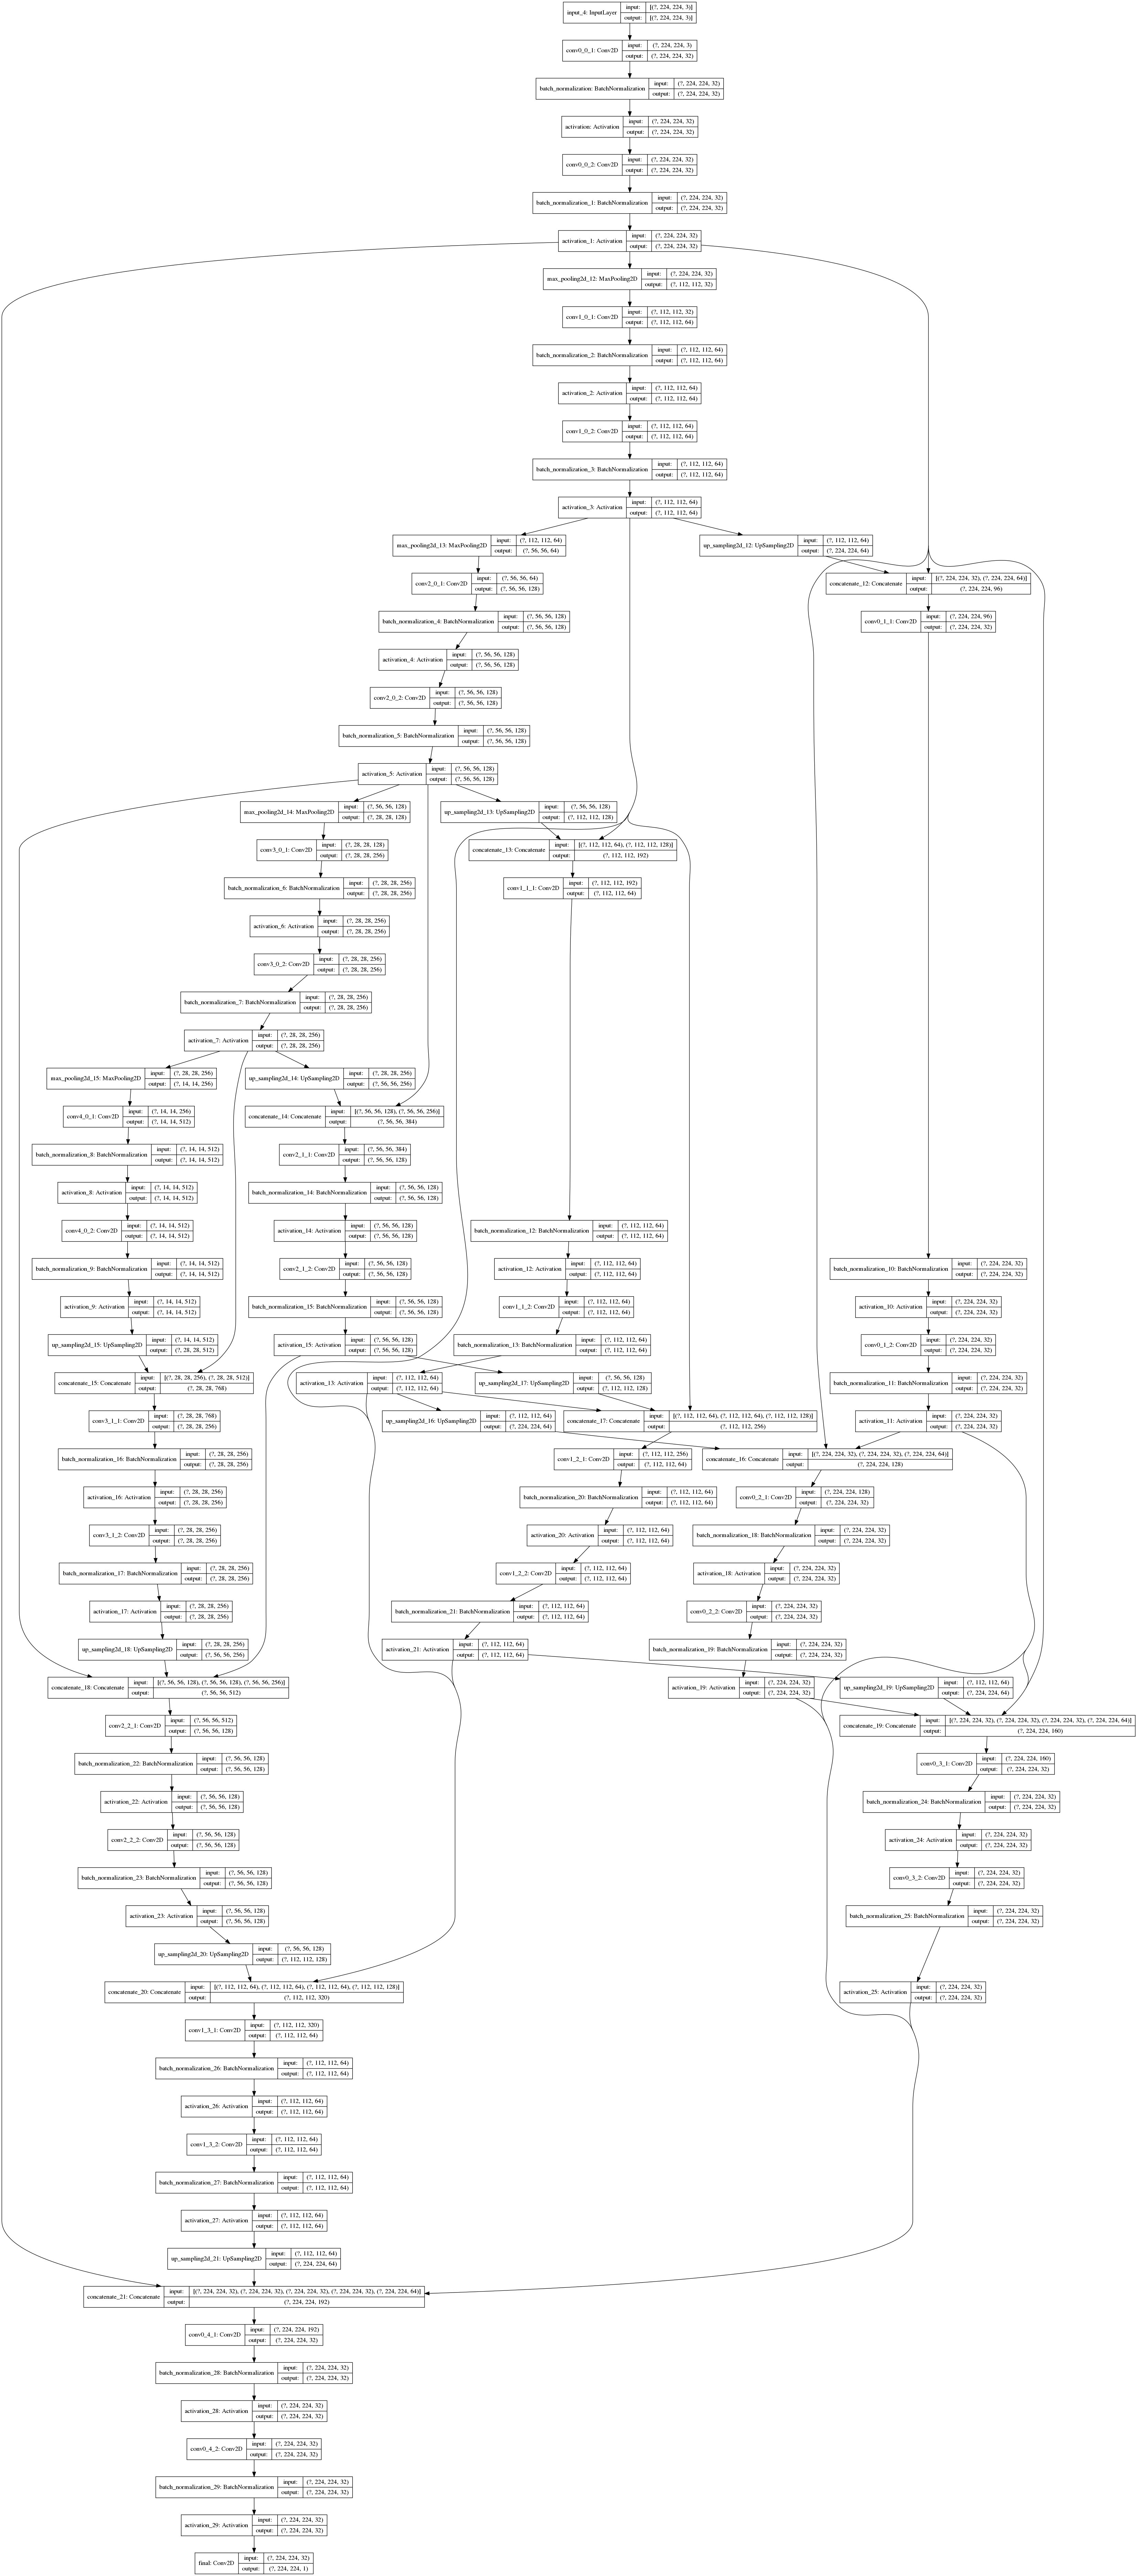

In [36]:
tf.keras.utils.plot_model(unet_pp, './UNet_Plus.png', show_shapes=True)

#### UNet++ class
---
```python
class UNet_Conv_Block(tf.keras.Model):
    def __init__(self, in_ch, out_ch):
        super(UNet_Conv_Block, self).__init__()
        self.activation = Activation('relu')
        self.conv1 = Conv2D(filters=in_ch, kernel_size=3, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filters=out_ch, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()
    
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)
        
        return output

class UNet_PP(tf.keras.Model):
    
    def __init__(self, classes=1):
        super(UNet_PP, self).__init__()
        
        n = 32
        filters = [n, n*2, n*4, n*8, n*16]
        
        
        self.maxpool = tf.keras.layers.MaxPooling2D(strides=2)
        self.upsample = tf.keras.layers.UpSampling2D()

        self.conv_block_0_0 = UNet_Conv_Block(filters[0], filters[0])
        self.conv_block_0_1 = UNet_Conv_Block(filters[0], filters[0])
        self.conv_block_0_2 = UNet_Conv_Block(filters[0], filters[0])
        self.conv_block_0_3 = UNet_Conv_Block(filters[0], filters[0])
        self.conv_block_0_4 = UNet_Conv_Block(filters[0], filters[0])
        
        self.conv_block_1_0 = UNet_Conv_Block(filters[1], filters[1])
        self.conv_block_1_1 = UNet_Conv_Block(filters[1], filters[1])
        self.conv_block_1_2 = UNet_Conv_Block(filters[1], filters[1])
        self.conv_block_1_3 = UNet_Conv_Block(filters[1], filters[1])
        
        self.conv_block_2_0 = UNet_Conv_Block(filters[2], filters[2])
        self.conv_block_2_1 = UNet_Conv_Block(filters[2], filters[2])
        self.conv_block_2_2 = UNet_Conv_Block(filters[2], filters[2])
        
        self.conv_block_3_0 = UNet_Conv_Block(filters[3], filters[3])
        self.conv_block_3_1 = UNet_Conv_Block(filters[3], filters[3])
        
        self.conv_block_4_0 = UNet_Conv_Block(filters[4], filters[4])
        
        self.final_layer = Conv2D(classes, 1, activation='softmax', name='final_layer')
    
    def build_Net(self, inputs) : #, input_shape=(224, 224, 3)):
        
        x0_0 = self.conv_block_0_0(inputs)
        
        x1_0 = self.conv_block_1_0(self.maxpool(x0_0))
        x0_1 = self.conv_block_0_1(Concatenate()([x0_0, self.upsample(x1_0)]))
        
        x2_0 = self.conv_block_2_0(self.maxpool(x1_0))
        x1_1 = self.conv_block_1_1(Concatenate()([x1_0, self.upsample(x2_0)]))
        x0_2 = self.conv_block_0_2(Concatenate()([x0_0, x0_1, self.upsample(x1_1)]))
        
        x3_0 = self.conv_block_3_0(self.maxpool(x2_0))
        x2_1 = self.conv_block_2_1(Concatenate()([x2_0, self.upsample(x3_0)]))
        x1_2 = self.conv_block_1_2(Concatenate()([x1_0, x1_1, self.upsample(x2_1)]))
        x0_3 = self.conv_block_0_3(Concatenate()([x0_0, x0_1, x0_2, self.upsample(x1_2)]))
        
        x4_0 = self.conv_block_4_0(self.maxpool(x3_0))
        x3_1 = self.conv_block_3_1(Concatenate()([x3_0, self.upsample(x4_0)]))
        x2_2 = self.conv_block_2_2(Concatenate()([x2_0, x2_1, self.upsample(x3_1)]))
        x1_3 = self.conv_block_1_3(Concatenate()([x1_0, x1_1, x1_2, self.upsample(x2_2)]))
        x0_4 = self.conv_block_0_4(Concatenate()([x0_0, x0_1, x0_2, x0_3, self.upsample(x1_3)]))
        
        output = self.final_layer(x0_4)
        
        return Model(inputs, output)

    
UNet_Plus = UNet_PP()
inputs = Input((224, 224, 3))
model = UNet_Plus.build_Net(inputs)
model.summary()
```

### bce + Dice coefficient (custom loss)

In [37]:
import keras.backend as K
from tensorflow.keras.losses import *

def custom_loss():
    
    def f_score(gt, pr, class_weights=1, beta=1, smooth=1, per_image=True, threshold=None):
        r"""The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
        where an F-score reaches its best value at 1 and worst score at 0.
        The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
        The formula for the F score is:
        .. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
            {\beta^2 \cdot precision + recall}
        The formula in terms of *Type I* and *Type II* errors:
        .. math:: F_\beta(A, B) = \frac{(1 + \beta^2) TP} {(1 + \beta^2) TP + \beta^2 FN + FP}
        where:
            TP - true positive;
            FP - false positive;
            FN - false negative;
        Args:
            gt: ground truth 4D keras tensor (B, H, W, C)
            pr: prediction 4D keras tensor (B, H, W, C)
            class_weights: 1. or list of class weights, len(weights) = C
            beta: f-score coefficient
            smooth: value to avoid division by zero
            per_image: if ``True``, metric is calculated as mean over images in batch (B),
                else over whole batch
            threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction prediction will not be round
        Returns:
            F-score in range [0, 1]
        """
        if per_image:
            axes = [1, 2]
        else:
            axes = [0, 1, 2]

        if threshold is not None:
            pr = K.greater(pr, threshold)
            pr = K.cast(pr, K.floatx())

        tp = K.sum(gt * pr, axis=axes)
        fp = K.sum(pr, axis=axes) - tp
        fn = K.sum(gt, axis=axes) - tp

        score = ((1 + beta ** 2) * tp + smooth) \
                / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)

        # mean per image
        if per_image:
            score = K.mean(score, axis=0)

        # weighted mean per class
        score = K.mean(score * class_weights)

        return score
    
    def dice_loss(gt, pr, class_weights=1., smooth=1, per_image=True, beta=1.):
        r"""Dice loss function for imbalanced datasets:
        .. math:: L(precision, recall) = 1 - (1 + \beta^2) \frac{precision \cdot recall}
            {\beta^2 \cdot precision + recall}
        Args:
            gt: ground truth 4D keras tensor (B, H, W, C)
            pr: prediction 4D keras tensor (B, H, W, C)
            class_weights: 1. or list of class weights, len(weights) = C
            smooth: value to avoid division by zero
            per_image: if ``True``, metric is calculated as mean over images in batch (B),
                else over whole batch
            beta: coefficient for precision recall balance
        Returns:
            Dice loss in range [0, 1]
        """
        return 1 - f_score(gt, pr, class_weights=class_weights, smooth=smooth, per_image=per_image, beta=beta)
    
    def bce_dice_loss(gt, pr, bce_weight=1., smooth=1, per_image=True, beta=1.):
        r"""Sum of binary crossentropy and dice losses:

        .. math:: L(A, B) = bce_weight * binary_crossentropy(A, B) + dice_loss(A, B)

        Args:
            gt: ground truth 4D keras tensor (B, H, W, C)
            pr: prediction 4D keras tensor (B, H, W, C)
            class_weights: 1. or list of class weights for dice loss, len(weights) = C 
            smooth: value to avoid division by zero
            per_image: if ``True``, dice loss is calculated as mean over images in batch (B),
                else over whole batch
            beta: coefficient for precision recall balance
        Returns:
            loss

        """
        bce = K.mean(binary_crossentropy(gt, pr))
        loss = bce_weight * bce + dice_loss(gt, pr, smooth=smooth, per_image=per_image, beta=beta)
        return loss
    return bce_dice_loss

In [38]:
unet_pp.compile(
    optimizer = Adam(lr=1e-4),
#     loss = my_loss(),
    loss = 'binary_crossentropy'
             )

In [39]:
unet_pp.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Epoch 1/100
22/22 [==============================] - 7s 297ms/step - loss: 0.4269 - val_loss: 0.5921
Epoch 2/100
22/22 [==============================] - 6s 291ms/step - loss: 0.2552 - val_loss: 0.4725
Epoch 3/100
22/22 [==============================] - 6s 291ms/step - loss: 0.1993 - val_loss: 0.4227
Epoch 4/100
22/22 [==============================] - 6s 292ms/step - loss: 0.1680 - val_loss: 0.3941
Epoch 5/100
22/22 [==============================] - 6s 292ms/step - loss: 0.1474 - val_loss: 0.3513
Epoch 6/100
22/22 [==============================] - 6s 292ms/step - loss: 0.1387 - val_loss: 0.2550
Epoch 7/100
22/22 [==============================] - 6s 293ms/step - loss: 0.1197 - val_loss: 0.1920
Epoch 8/100
22/22 [==============================] - 6s 294ms/step - loss: 0.1025 - val_loss: 0.2003
Epoch 9/100
22/22 [==============================] - 6s 293ms/step - loss: 0.1159 - val_loss: 0.1089
Epoch 10/100
22/22 [==============================] - 6s 294ms/step - loss: 0.1058 - val_lo

In [40]:
unet_pp.save('./unet_pp.h5')

# U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

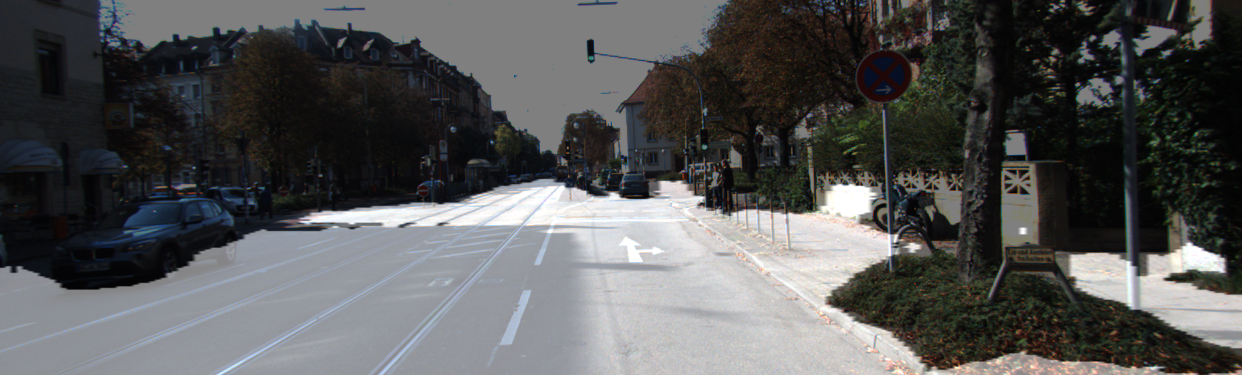

In [56]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

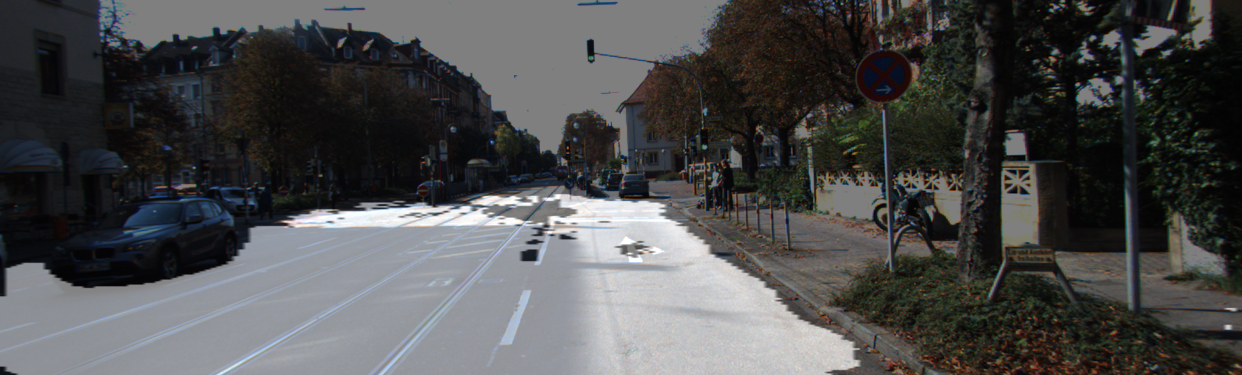

In [57]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [41]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [43]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [44]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.912766


0.9127662882910901

In [45]:
# unet = tf.keras.models.load_model('unet.h5')

In [55]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.777196


0.7771956087824351

# 정리
---
1. KITTI 데이터셋 확인
    - ```semantic``` 디렉토리에 있는 segmentation 마스킹 이미지를 뜯어보면 다음과 같이 다양한 클래스를 확인할 수 있다.
    - 클래스 7의 경우 도로에 대한 정보를 담고 있는 것을 확인할 수 있다.  
        ![image](https://user-images.githubusercontent.com/48716219/98630838-5a5f6a80-235f-11eb-943d-2b2e90066916.png)  
        
<br>  

2. Augmentation 적용
    - albumentation 라이브러리 활용  
        ![image](https://user-images.githubusercontent.com/48716219/98632834-998fba80-2363-11eb-847a-acd1466f990f.png)  
    - augmentation 후, 원본 데이터와 segmentation 마스킹 이미지 시각화  
        ![image](https://user-images.githubusercontent.com/48716219/98636009-50426980-2369-11eb-9d50-6c92c993484f.png)

<br>  

3. U-Net++ 모델 구현
    - 기존의 U-Net 모델의 skip connectio이  DesnseNet의 Dense connectivity를 적용  
        ![image](https://user-images.githubusercontent.com/48716219/98207024-59ed5b00-1f7e-11eb-8bee-9daec27ddb62.png)
    -  ```build_UNet```, ```build_Unet_Plus``` 함수 선언, 각각 UNet과 UNet++모델을 반환  
    
<br>  

4. 결과 비교
    - U-Net : IoU = 0.777  
        ![image](https://user-images.githubusercontent.com/48716219/98636812-e4610080-236a-11eb-8553-a53abd117b67.png)
    - U-Net++ : IoU = 0.912  
        ![image](https://user-images.githubusercontent.com/48716219/98636993-2db15000-236b-11eb-8cc8-31fa08955a9a.png)
    - U-Net의 경우 생각보다 잘 찾은 것 같지만 인도 영역까지 segmentation을 했다. 그에 반해 U-Net++는 인도를 제외한 도로의 영역만 찾아냈고 실제로 IoU수치도 약 0.14정도 U-Net++의 성능이 더 좋게 나왔다.